## Approach ##
- Read reasonable number of videos into memory
- Convert into Dataset using tf.data.Dataset.from_tensor_slices()
- Predict using this Dataset

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

from werdich_cfr.utils.processing import Videoconverter
from werdich_cfr.tfutils.TFRprovider import DatasetProvider

In [2]:
# Directories and parameters: use image data from a trained model
cfr_dir = os.path.normpath('/mnt/obi0/andreas/data/cfr')
tfr_dir = os.path.join(cfr_dir, 'tfr_200304')
log_dir = os.path.join(cfr_dir, 'log', 'inc2_restmbf_0318gpu2')
model_name = 'inc2_restmbf0318gpu2'

# We need the model_dict for the correct image transformations
model_dict_file = os.path.join(log_dir, model_name+'_model_dict.pkl')
with open(model_dict_file, 'rb') as fl:
    model_dict = pickle.load(fl)
batch_size = 8

In [3]:
# Get image data from TFRecords
tfr_file = os.path.join(tfr_dir, 'cfr_resized75_a4c_test_200304_0.tfrecords')
tfr_df_file = tfr_file.replace('.tfrecords', '.parquet')
tfr_df = pd.read_parquet(tfr_df_file)
print(tfr_df[['filename', 'rest_mbf_unaff']].head())

testset_provider = DatasetProvider(im_scale_factor=model_dict['im_scale_factor'],
                                   model_output=model_dict['model_output'])

testset_tfr = testset_provider.make_batch(tfr_file_list=[tfr_file], 
                                          batch_size=batch_size,
                                          shuffle=False,
                                          buffer_n_steps=None,
                                          repeat_count=1,
                                          drop_remainder=False)

# Take the first batch from the dataset
element = testset_tfr.take(1)
batch = list(element.as_numpy_iterator())[0]
print(*batch[1]['score_output'], sep='\n')

                                                filename  rest_mbf_unaff
42017  4a1ed433438d40d2_4903a585842982285838237d20c4_...        1.080000
15810  48b5f81b2a1f902f_4903a58050942a0db5220a677e23_...        0.534000
93061  4a1047fca7d476c4_4903a444c30abb39c05a8f16ddd7_...        1.213250
29945  4907bd6e08391c19_4903a584a1b88b140f97ee834b43_...        1.139200
22448  4904b3677f43987c_4903a5864e642e4d47ed205b3388_...        0.797625
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
1.08
0.534
1.21325
1.1392
0.797625
1.0281177
0.99588233
0.7579412


In [4]:
element

<TakeDataset shapes: ({video: (None, None, 299, 299, 1)}, {score_output: (None,)}), types: ({video: tf.float32}, {score_output: tf.float32})>

In [5]:
print(batch[0].keys())
print(batch[0]['video'].shape)

dict_keys(['video'])
(8, 40, 299, 299, 1)


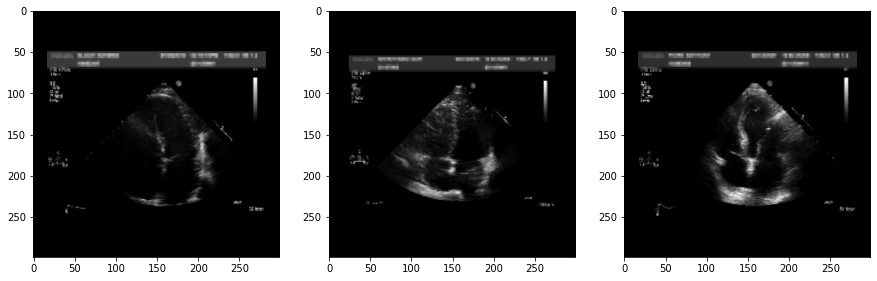

In [6]:
frame = 10
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    im = batch[0]['video'][idx, frame, :, :, 0]
    ax[idx].imshow(im, cmap='gray')

Reproduce this result from files loaded into memory.

In [7]:
# Video list
test_predict_file = 'cfr_resized75_a4c_test_200304.parquet'
test_predict_df = pd.read_parquet(os.path.join(log_dir, test_predict_file))
test_cols = ['filename', 'rest_mbf_unaff', 'label', 'pred']
test_df = test_predict_df[test_cols]
print(test_df.head())

# The latest meta data
meta_dir = os.path.join(cfr_dir, 'metadata_200320')
meta_df = pd.read_parquet(os.path.join(meta_dir, 'echo_BWH_meta_200320.parquet'))

                                            filename  rest_mbf_unaff     label      pred
0  4a1ed433438d40d2_4903a585842982285838237d20c4_...        1.080000  1.080000  0.674374
1  48b5f81b2a1f902f_4903a58050942a0db5220a677e23_...        0.534000  0.534000  0.922969
2  4a1047fca7d476c4_4903a444c30abb39c05a8f16ddd7_...        1.213250  1.213250  0.836842
3  4907bd6e08391c19_4903a584a1b88b140f97ee834b43_...        1.139200  1.139200  0.788347
4  4904b3677f43987c_4903a5864e642e4d47ed205b3388_...        0.797625  0.797625  0.875234


In [8]:
vc = Videoconverter(min_rate=21, min_frames=40, meta_df=meta_df)

In [9]:
filename = test_df.filename.iloc[0]
im = vc.process_video(filename)
print(im.shape)

(169, 225, 40)


In [11]:
video_list = list(test_df.filename.values)
im_array_list = []
for f, filename in enumerate(video_list[0:16]):
    im = vc.process_video(filename)
    print('Loaded video {} of {} into memory. Shape: {}'.format(f+1, len(video_list), im.shape))
    im_array_list.append((im, np.asarray(im.shape, np.int32)))

Loaded video 1 of 585 into memory. Shape: (169, 225, 40)
Loaded video 2 of 585 into memory. Shape: (159, 212, 40)
Loaded video 3 of 585 into memory. Shape: (169, 225, 40)
Loaded video 4 of 585 into memory. Shape: (154, 225, 40)
Loaded video 5 of 585 into memory. Shape: (119, 159, 40)
Loaded video 6 of 585 into memory. Shape: (178, 237, 40)
Loaded video 7 of 585 into memory. Shape: (169, 225, 40)
Loaded video 8 of 585 into memory. Shape: (159, 212, 40)
Loaded video 9 of 585 into memory. Shape: (119, 159, 40)
Loaded video 10 of 585 into memory. Shape: (188, 251, 40)
Loaded video 11 of 585 into memory. Shape: (198, 264, 40)
Loaded video 12 of 585 into memory. Shape: (178, 237, 40)
Loaded video 13 of 585 into memory. Shape: (198, 264, 40)
Loaded video 14 of 585 into memory. Shape: (178, 237, 40)
Loaded video 15 of 585 into memory. Shape: (163, 239, 40)
Loaded video 16 of 585 into memory. Shape: (213, 320, 40)


In [12]:
# MAKE A DATA SET USING A GENERATOR

def im_generator():
    for element in im_array_list:
        yield (element[0], element[1])

dsp = DatasetProvider(augment=False, im_scale_factor=model_dict['im_scale_factor']) 

dset = tf.data.Dataset.from_generator(generator=im_generator,
                                      output_types=(tf.int32, tf.int32),
                                      output_shapes=(tf.TensorShape([None, None, 40]), tf.TensorShape([3])))

dset = dset.map(dsp._process_image)

# Now, we just have to replace the tensor by a dict
dset = dset.map(lambda x: ({'video': x}, {'score_output': 0}))

# Then we can batch it
dset = dset.batch(batch_size)
dset = dset.repeat(count=1)


element = dset.take(1)
output = list(element.as_numpy_iterator())[0]

In [22]:
print(batch[0].keys())
print(batch[0]['video'].shape)

dict_keys(['video'])
(8, 40, 299, 299, 1)


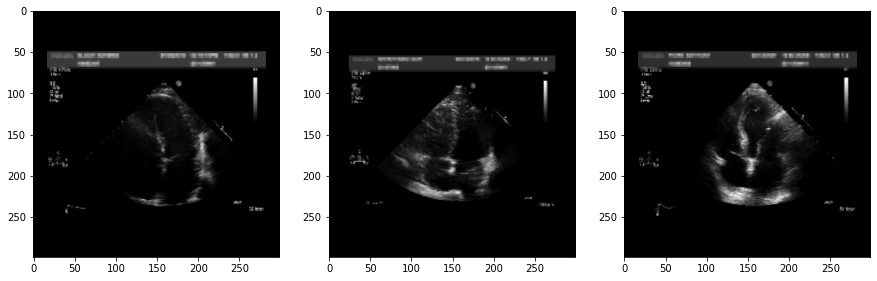

In [23]:
frame = 10
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    im = batch[0]['video'][idx, frame, :, :, 0]
    ax[idx].imshow(im, cmap='gray')